### Import Dependencies

In [1]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery, Document

from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage, convert_to_openai_messages

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import instructor
import inspect
import json

from utils.utils import get_tool_descriptions, format_ai_message

/Users/hanlinyang/Projects/AI/ai_bootcamp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Retrieval Tool

In [2]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embeddings(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=text,
        model=model
    )

    current_run = get_current_run_tree()
    if current_run:
        current_run.metadata["usage_metadata"] = {
            "input_tokens": response.usage.prompt_tokens,
            "total_tokens": response.usage.total_tokens
        }

    return response.data[0].embedding

@traceable(
    name="retrieve_data",
    run_type="retriever"
)
def retrieve_data(query, k=5):

    query_embedding = get_embeddings(query)

    qdrant_client = QdrantClient(url="http://localhost:6333")

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search-v2",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(text=query, model="Qdrant/bm25"),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k
    )

    retrieved_context_ids = []
    retrieved_context= []
    similiarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload['parent_asin'])
        retrieved_context.append(result.payload['description'])
        similiarity_scores.append(result.score)
        retrieved_context_ratings.append(result.payload['average_rating'])

    return {
        "retrieved_context_ids": retrieved_context_ids,
        "retrieved_context": retrieved_context,
        "similiarity_scores": similiarity_scores,
        "retrieved_context_ratings": retrieved_context_ratings
    }

@traceable(
    name="format_retrieved_context",
    run_type="prompt"
)
def process_context(context):

    formatted_context = ""

    for id, chunk, rating in zip(context['retrieved_context_ids'], context['retrieved_context'], context['retrieved_context_ratings']):
        formatted_context += f"- ID: {id}, Rating: {rating}, Description: {chunk}\n"

    return formatted_context


def get_formatted_context(query: str, top_k: int =5) -> str:

    """
    Get the top k context, each representing an inventory item for a given query.

    Args:
        query (str): The query to get the context for.
        top_k (int): The number of context chunks to retrieve, works best with 5 or more

    Returns:
        A string of the top k context chunks with IDs and average ratings prepending to each chunk, each represending an inventory item a given query.
    """

    context = retrieve_data(query, top_k)

    formatted_context = process_context(context)

    return formatted_context

#### State and Pydantic Model for Structured Outputs

In [3]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class RAGUsedContext(BaseModel):
    id: str = Field(description="The id of the item used to answer the question")
    description: str = Field(description="Short description of the item used to answer the question")

class AgentResponse(BaseModel):
    answer: str = Field(description="The answer to the question")
    references: List[RAGUsedContext] = Field(description="The list of the items used to answer the question")
    final_answer: bool = False
    tool_calls: List[ToolCall] = []

class State(BaseModel):
    messages: Annotated[List[Any], add] =[]
    question_relevant: bool = False
    iteration: int = 0
    answer: str = ""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[ToolCall] = []
    final_answer: bool = False
    references: Annotated[List[RAGUsedContext], add] = []
    

In [4]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4o-mini"}
)
def agent_node(state: State):

    prompt_template = """You are a shopping assistant that can answer questions about the products in stock.

You will be given a conversation history and a list of tools you can use to answer the latest query.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

When making tool calls, use this exact format:
{
  "name": "tool_name",
  "arguments": {
    "parameter1": "value1",
    "parameter2": "value2"
  }
}

CRITICAL: All parameters must go inside the "arguments" object, not at the top level of the tool call.

Examples:
Get formatted item context:
{
  "name": "get_formatted_item_context",
  "arguments": {
    "query": "Kool kids toys",
    "top_k": 5
  }
}

CRITICAL RULES:
- If tool_calls has values, final_answer MUST be false.
  (You cannot call tools and exit the graph in the same response)
- If final_answer is true, tool_calls MUST be []
- You must wait for tool results before exiting the graph
- If you need tool results before answering, set:
  tool_calls=[...], final_answer=false
- After receiving tool results, you can then set:
  tool_calls=[], final_answer=true
- Use names specifically provided in the available tools. Don't add any additional text to the names.

Instructions:
- You need to answer the question based on the outputs from the tools using the available tools only.
- Do not suggest the same tool call more than once.
- If the question can be decomposed into multiple sub-questions, suggest all of them.
- If multiple tool calls can be used at once to answer the question, suggest all of them.
- Do not explain your next steps in the answer, instead use tools to answer the question.
- Never use word context and refer to it as the available products.
- You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.

As an output you need to return the following:

* answer: The answer to the question based on your current knowledge and the tool results.
* references: The list of the indexes from the chunks retrieved from all tool calls that were used to answer the question. If more than one chunk was used to compile the answer from a single tool call, be sure to return all of them.
* Each reference should have an id and a short description of the item based on the retrieved context.
* final_answer: True if you have all the information needed to provide a complete answer, False otherwise.

- The answer to the question should contain detailed information about the product and should be returned with detailed specification in bullet points.
- The short description should have the name of the item.
- If the user's request requires using a tool, set tool_calls with the appropriate function names and arguments.
"""

    template = Template(prompt_template)

    prompt = template.render(
        available_tools=state.available_tools
    )

    messsages = state.messages

    conversations =[]

    for message in messsages:
        conversations.append(convert_to_openai_messages(message))

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4o-mini",
        response_model=AgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversations],
        temperature=0.5
    )

    ai_message = format_ai_message(response)

    return {
        "messages": [ai_message],
        "tool_calls": response.tool_calls,
        "iteration": state.iteration + 1,
        "answer": response.answer,
        "final_answer": response.final_answer,
        "references": response.references
    }

#### Tool Router Edge

In [5]:
def tool_router(state: State) -> str:
    """
    Decide whether to contine to end
    """

    if state.final_answer:
        return "end"
    elif state.iteration > 2:
        return "end"
    elif len(state.tool_calls) > 0:
        return "tool_node"
    else:
        return "end"

#### Intent Router

In [6]:
class IntentRouterResponse(BaseModel):
    question_relevant: bool
    answer: str

In [7]:
from langchain_core.messages import convert_to_openai_messages


@traceable(
    name="intent_router_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def intent_router_node(state: State):

    prompt_template = """
You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to classify it into relevant or not relevant.
- If the question is not relevant, return False in field "question_relevant" and set "answer" to explain why it is not relevant.
- If the question is relevant, return True in field "question_relevant" and set "answer" to "".
- You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.
"""

    template = Template(prompt_template)

    prompt = template.render()

    messsages = state.messages

    conversations =[]

    for message in messsages:
        conversations.append(convert_to_openai_messages(message))

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": prompt},
            *conversations
        ],
        response_model=IntentRouterResponse,
    )

    return {
        "question_relevant": response.question_relevant,
        "answer": response.answer
    }

In [8]:
def intent_router_conditional_edges(state: State):

    if state.question_relevant:
        return "agent_node"
    else:
        return "end"


#### Graph

In [9]:
workflow = StateGraph[State, None, State, State](State)

tools = [get_formatted_context]
tool_node = ToolNode(tools)
tool_descriptions = get_tool_descriptions(tools)

workflow.add_node("agent_node", agent_node)
workflow.add_node("tool_node", tool_node)
workflow.add_node("intent_router_node", intent_router_node)

workflow.add_edge(START, "intent_router_node")
workflow.add_conditional_edges(
    "intent_router_node",
    intent_router_conditional_edges,
    {
        "agent_node": "agent_node",
        "end": END
    }
)
workflow.add_conditional_edges(
    "agent_node",
    tool_router,
    {
        "tool_node": "tool_node",
        "end": END
    }
)
workflow.add_edge("tool_node", "agent_node")

graph = workflow.compile()

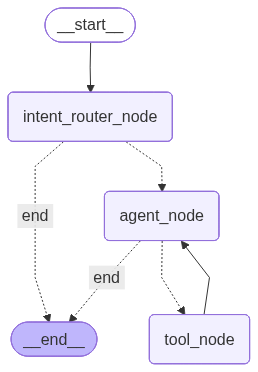

In [10]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
initial_state = {
    "messages": [
        {"role": "user", "content": "Can I get a tablet for my kid, a watch for my wife, and a laptop for myself? make your best judgement on the details of the products"}
    ],
    "available_tools": tool_descriptions
}

In [12]:
initial_state

{'messages': [{'role': 'user',
   'content': 'Can I get a tablet for my kid, a watch for my wife, and a laptop for myself? make your best judgement on the details of the products'}],
 'available_tools': [{'name': 'get_formatted_context',
   'description': 'Get the top k context, each representing an inventory item for a given query.',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string', 'description': ''},
     'top_k': {'type': 'integer', 'description': '', 'default': 5}}},
   'required': ['query'],
   'returns': {'type': 'string',
    'description': 'A string of the top k context chunks with IDs and average ratings prepending to each chunk, each represending an inventory item a given query.'}}]}

In [13]:
result = graph.invoke(initial_state)

In [14]:
result

{'messages': [{'role': 'user',
   'content': 'Can I get a tablet for my kid, a watch for my wife, and a laptop for myself? make your best judgement on the details of the products'},
  AIMessage(content='I will retrieve the available products for a tablet, a watch, and a laptop to provide you with detailed specifications for each item.', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'get_formatted_context', 'args': {'query': 'tablet', 'top_k': 5}, 'id': '0', 'type': 'tool_call'}, {'name': 'get_formatted_context', 'args': {'query': 'watch', 'top_k': 5}, 'id': '1', 'type': 'tool_call'}, {'name': 'get_formatted_context', 'args': {'query': 'laptop', 'top_k': 5}, 'id': '2', 'type': 'tool_call'}], invalid_tool_calls=[]),
  ToolMessage(content='- ID: B0B6ZZH83Y, Rating: 4.1, Description: iFongsh Tablet Stand Tripod, 80\'\' Tablet Stand Floor, Adjustable Gooseneck Tablet Stand with Tablet and Phone Holder Compatible with iPad Pro 12.9, Mini, Air, iPhone, All 4.7"-13" Tablet a

In [ ]:
print(result["answer"])

### Tablet Options for Kids:
1. **PRITOM Tablet for Kids**  
   - **Rating:** 4.1  
   - **Specifications:**  
     - 7 inch display  
     - 32GB ROM, 2GB RAM  
     - WiFi, Bluetooth, Camera  
     - Parental Control features  
     - Pre-installed educational apps and games  
     - Kid-proof case included  
     - Ideal for ages 3-12  
     - **Description:** A kid-friendly tablet designed for educational and entertaining purposes, featuring a child-friendly interface and safety controls.  

2. **URAO 8 inch Kids Tablet**  
   - **Rating:** 4.3  
   - **Specifications:**  
     - 8 inch display  
     - Android 10, Parental Control  
     - 2GB RAM, 32GB ROM  
     - Quad Core Processor  
     - Eye Protection Technology  
     - **Description:** This tablet is designed for kids with a focus on learning and safety, featuring various educational apps and parental controls.  

### Watch Options for Your Wife:
1. **Zhizhi Smart Watch for Men Women**  
   - **Rating:** 4.1  
   - **Spe